#### Notebook includes



- Notebook purpose description
- Data loading
- Partial seismic 2008 and 2011 side by side plot before scaling
- Volve 2011 and 2009 acoustic impedance comparison
- Old and new vintage data distirbution comparison
- Conclusion



#### Notebook purpose

In this notebook the purpose is to discover the data discrepancy that causes predictions when using ST10010ZC11 vintage to be different in terms of the predictions ranges. Acoustic impedance and partial seismic are the potential sources that cause the issue, and thus ST10010ZC11 and ST0202R08 survey measurement will be compared before and after scaling

In [47]:
import sys
import yaml 
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow.keras as K
from tensorflow import keras
import numpy as np
import os
sys.path.append('../')
from sklearn.preprocessing import RobustScaler
from utils.plotting_utils import plot_wells_dataset_in_map
from models.models import MyModel
from utils.seis_utils import batch_trace_attributes, seismic_attribute
from utils.utils import limit_gpu_memory_for_process
from train.preprocessing import create_dataset
import geopandas as gpd
import joblib
%matplotlib inline


import seaborn as sns
import xarray as xr 
sns.set()

In this notebook we will train a TCN model with the aim to predict Acoustic impedance from the seismic traces. 
The aim of the model is to map a relationship of the seismic traces for different partial stacks and their corresponding seismic attributes. For simplification, we will just look at the envelope of each trace.

The model will be constrained to be trained and predict on the Lista and Heimdal Formations. 

First, we want to set up the different training parameters, training data, as well as the validation and test for this experiment. All this setup is describe in a config.yaml file.  

In [48]:
output_dir = '../tests/baseline/zp0/' 

yaml_path = output_dir+'config.yaml'
f = open(yaml_path, 'r')
config = yaml.load(f, Loader=yaml.Loader)

os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '0'

limit_gpu_memory_for_process(0.3)

/home/samir/volve_new/env/lib/python3.7/site-packages/tensorflow/python/client/session.py:1768: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [49]:
for k,v in config.items():
    print({k:v})

{'data_file': ['../data/well_seismics/well_logs_torolfv3_with_seismic1ms.csv']}
{'model': {'model': 'TCN', 'filters': 128}}
{'features': ['twt', 'seis_near', 'seis_nearmid', 'seis_mid', 'seis_far']}
{'targets': ['zp']}
{'seismic_attributes': ['envelope', 'phase', 'cosine_of_phase']}
{'formations': ['LISTA FM', 'HEIMDAL FM']}
{'train': {'lr': 0.0001, 'epochs': 200}}
{'data': {'train': {'well_names': ['15/9-F-1 A', '15/9-19 A', '15/9-F-1 C', '15/9-F-1', '15/9-F-11 B', '15/9-F-11 T2', '15/9-F-12', '15/9-F-14', '15/9-F-15 D', '15/9-F-5', '15/9-F-15 A']}, 'val': {'well_names': ['15/9-19 BT2']}, 'test': {'well_names': ['15/9-19 BT2']}}}


In [50]:
data_file = config['data_file'][0]
formations = config['formations']
data = config['data']
wells_train = data['train']['well_names']
wells_val = data['val']['well_names']
wells_test = data['test']['well_names']
features = config['features']
targets = config['targets']
seismic_attributes = config['seismic_attributes']
used_wells = wells_train+wells_val+wells_test

# Load Data

We load the well-seimic data derived from both ST10010ZC11 and ST0202R08 seismic vintages. We are interested in plotting partial seismic and acoustic impedance to compare the ranges. We will be using 15/9-19 BT2 for the plotting simplicity.



In [51]:
survey = gpd.read_file('../data/Shapefiles/seismic.shp') # Layout of the survey 

well_datac=pd.read_csv(data_file)
#well_datac['seis_grad'] = well_datac['seis_far']-well_datac['seis_near']

well_datac = well_datac.loc[well_datac.well.isin(used_wells)]

well_datac.twt


well_datac_test = pd.read_csv('../data/well_seismics/well_logs_torolfv3_with_new_seismic1ms.csv')
well_datac_test = well_datac_test.loc[well_datac_test.well.isin(test)]

Getting a mask to filter the dataset to contain BT2 well data only

In [52]:
test = ['15/9-19 BT2']

well_datac=pd.read_csv(data_file)
well_datac_bt = well_datac.loc[well_datac.well.isin(test)]

well_datac_test = pd.read_csv('../data/well_seismics/well_logs_torolfv3_with_new_seismic1ms.csv')
well_datac_test = well_datac_test.loc[well_datac_test.well.isin(test)]



well_datac_test = well_datac_test.loc[well_datac_test['formations'].isin(formations)]
well_datac_bt = well_datac_bt.loc[well_datac_bt['formations'].isin(formations)]

Rename partial seismic in the 2011 survey dataset to make sure old and newer vintage have the same column names

In [53]:
well_datac_test.rename(columns={'far_seis': 'seis_far', 'mid_seis': 'seis_mid', 'near_seis':'seis_near', 'near_mid_seis': 'seis_nearmid'}, inplace=True)
well_datac

well_datac_test.columns

Index(['gr', 'rdep', 'den', 'ac', 'den_pred', 'ac_pred', 'acs_pred',
       'den_join', 'ac_join', 'acs_join', 'vsh', 'phit', 'phie', 'swe', 'md',
       'vp_original', 'density_original', 'zp_original', 'vp', 'vs', 'rho',
       'zp', 'zs', 'vpvs', 'x', 'y', 'z', 'tvd', 'dx', 'dy', 'azim_tn', 'incl',
       'dls', 'azim_gn', 'tvd_msl', 'md_msl', 'il', 'xl', 'il_sample',
       'xl_sample', 'twt_vsp', 'seis_far', 'seis_mid', 'seis_nearmid',
       'seis_near', 'twt', 'well', 'acs', 'vs_original', 'zs_original',
       'vpvs_original', 'twt_funct', 'formations'],
      dtype='object')

### Partial seismic 2008 and 2011 side by side plot before scaling

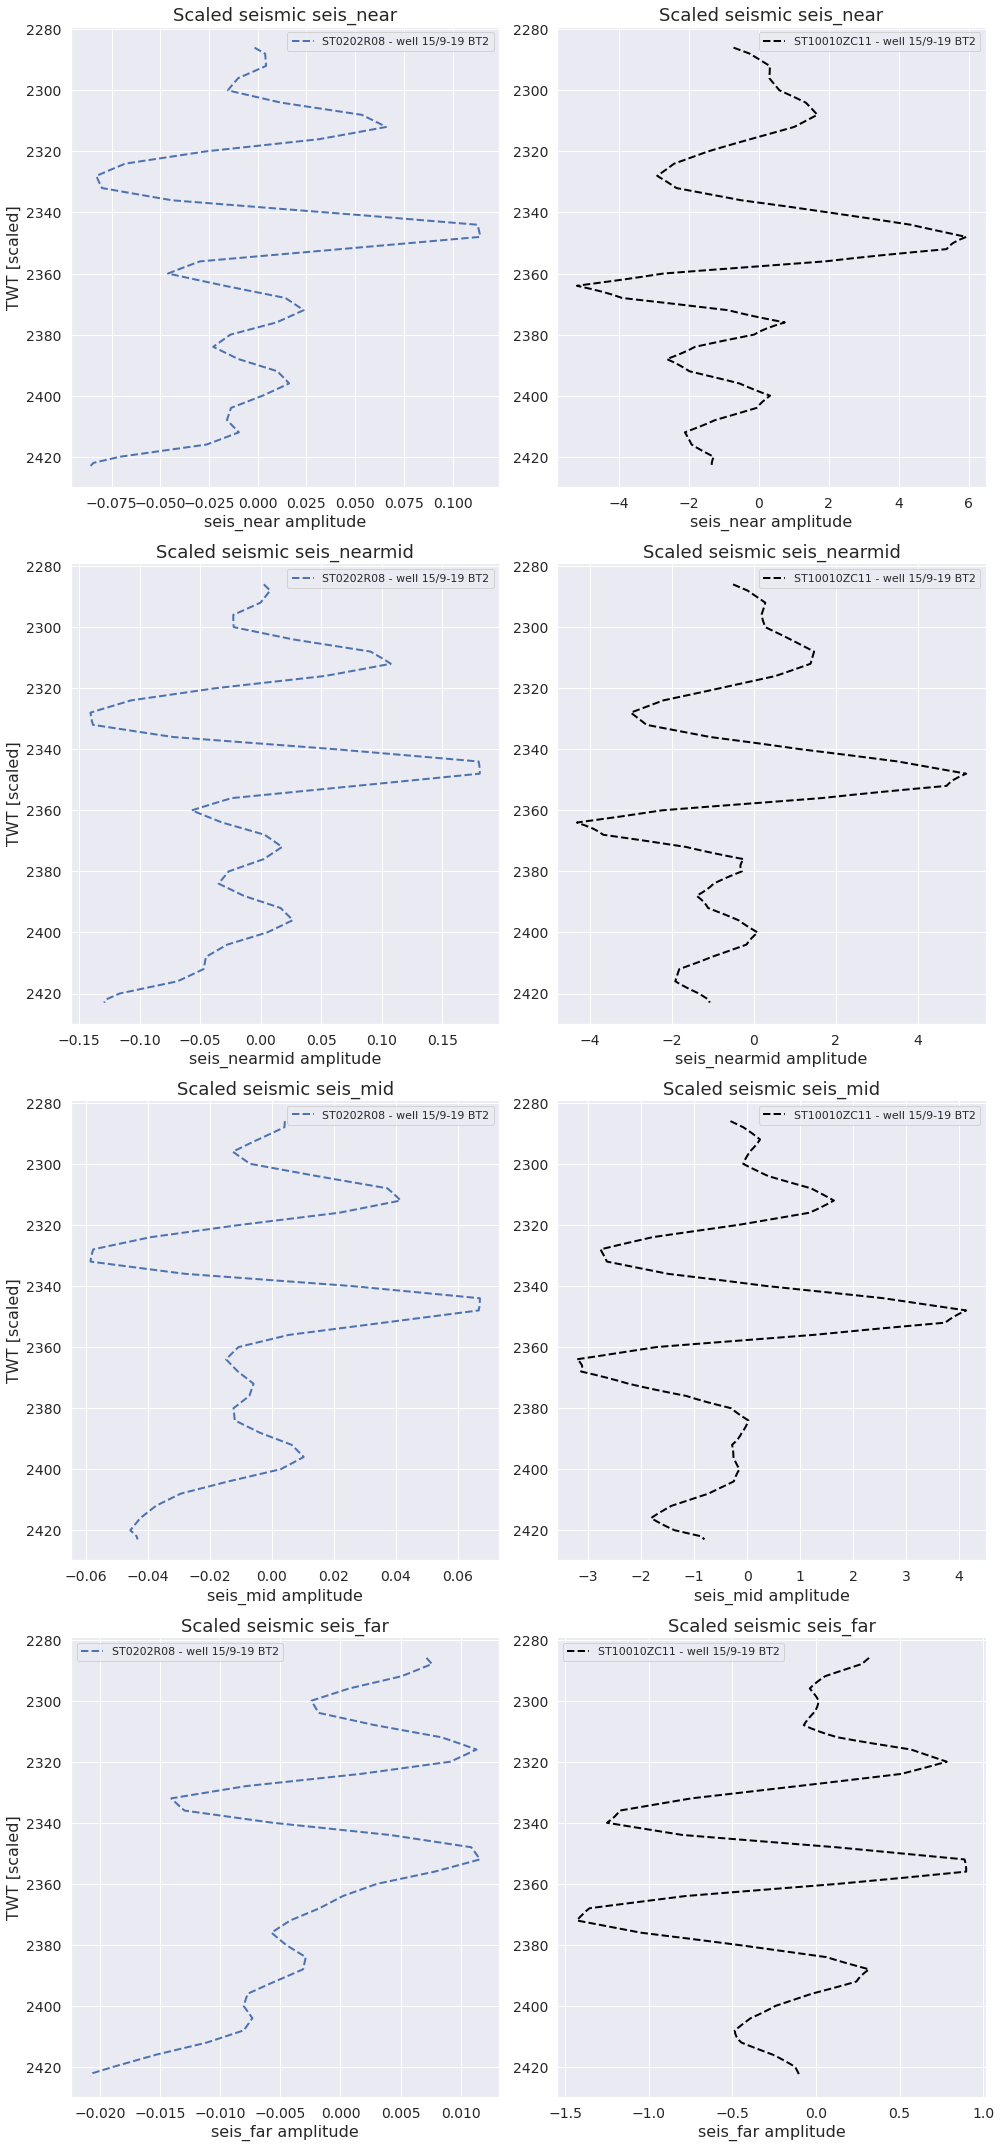

In [54]:
#  Categorical Data
features = ['seis_near', 'seis_nearmid', 'seis_mid', 'seis_far']


#  Categorical Data
a = 4  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(14,30))


for feature in features:

    plt.subplot(a, b, c)
    plt.plot(well_datac_bt[feature], well_datac_bt.twt ,lw=2, ls = '--', label = f'ST0202R08 - well {well_datac_bt.well.unique()[0]}')
    plt.title('Scaled seismic {}'.format(feature), fontsize = 18)
    plt.ylabel('TWT [scaled]', fontsize = 16)
    plt.xlabel(f'{feature} amplitude', fontsize = 16)

    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.gca().invert_yaxis()

    plt.legend()

    plt.subplot(a, b, c+1)
    plt.plot(well_datac_test[feature], well_datac_test.twt , color= 'black',lw=2, ls = '--', label = f'ST10010ZC11 - well {well_datac_test.well.unique()[0]}')
    plt.title('Scaled seismic {}'.format(feature), fontsize = 18)
    plt.xlabel(f'{feature} amplitude', fontsize = 16)


    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
    plt.gca().invert_yaxis()

    plt.legend()
    c +=2

plt.subplots_adjust(wspace = 2) 
plt.subplots_adjust(hspace = 2) 
plt.tight_layout()  

The magnitude of the amplitudes of the 2008 vintage (left) and the 2011 vintage (right) varies significantly. Special attention shluld be paid to the difference in the magntiude in the x-axis scale. From the other side we see that they are similar in terms of the shape except some of the intervals. This is how we make sure that there should not be some mechanical error during the data collection, such as seismic cubes formation or well-seismic data merge. We are esentially looking at the same site while using 2 different surveys

#### Volve 2011 and 2009 acoustic impedance comparison


We want to compare Volve 2009 and 2011 seismic data and log data to make sure that they are within the same ranges

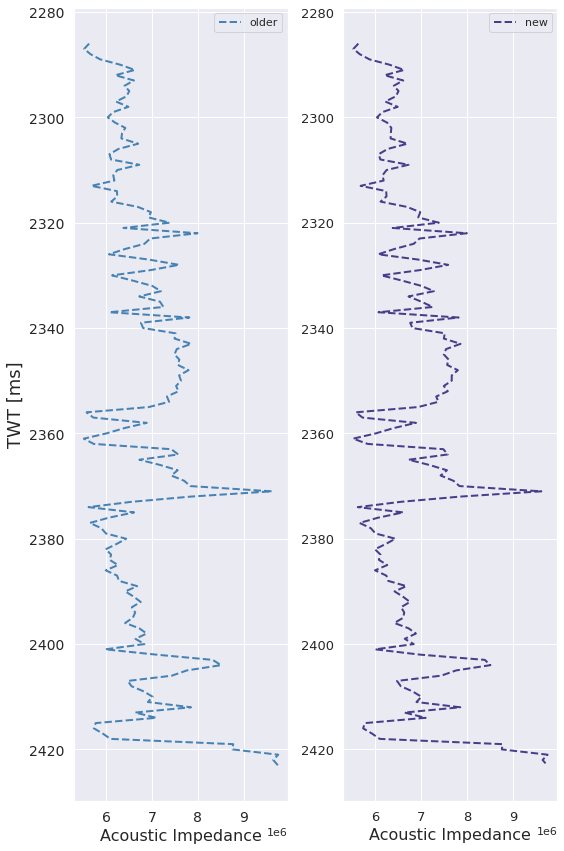

In [55]:
# Subplot if we need to do side by side

fig,ax = plt.subplots(figsize=(8,12),ncols=2) 

ax[0].plot(well_datac_bt.zp, well_datac_bt.twt , 'steelblue',lw=2, ls = '--', label = 'older')

ax[0].legend(loc = 'upper right')
ax[1].plot(well_datac_test.zp, well_datac_test.twt,color='darkslateblue',lw=2, ls = '--',alpha=1, label = 'new')
ax[1].legend(loc = 'best')


# ax[0].set_ylim([2330, 2500])

ax[0].invert_yaxis()
ax[0].tick_params(axis='both', which='major', labelsize=14)
ax[0].set_xlabel('Acoustic Impedance', fontsize=16)
ax[0].set_ylabel('TWT [ms]', fontsize=18)



#
ax[1].invert_yaxis()
ax[1].set_xlabel('Acoustic Impedance', fontsize=16)
ax[1].tick_params(axis='both', which='major', labelsize=13)


plt.rc('legend',fontsize=14)
# plt.gca().invert_yaxis()

# fig.suptitle('Ragnarock AI measured/Das ', y = 1, fontsize = 16)


plt.tight_layout()


We make sure that acoustic impedance is within the same range of the values. Thus, acoustic impedance shouldn't cause an important difference in the predictions. Below one can find histograms of the partial seismic values colored by the survey. 

The main point here is to 1) Scale data same way we do before the predictions 2) Compare partial seismic distribution after scaling

In [57]:
well_datac.set_index(['well'], inplace=True)
well_datac = well_datac.loc[well_datac['formations'].isin(formations)]

data = well_datac.copy()
data.dropna(axis=0,how='all',inplace=True,subset=targets) 

logs = set(features + targets + ['formations','gr','twt'])
well_datac = well_datac[logs]
well_datac.dropna(inplace=True)


### test
well_datac_test.set_index(['well'], inplace=True)
well_datac_test = well_datac_test.loc[well_datac_test['formations'].isin(formations)]

data_test = well_datac_test.copy()
data_test.dropna(axis=0,how='all',inplace=True,subset=targets) 

logs_test = set(features + targets + ['formations','gr','twt'])
well_datac_test = well_datac_test[logs]
well_datac_test.dropna(inplace=True)




In [65]:
# set up old and new vintage dataset same way as we do before the predictions.


dataset_train = create_dataset(well_datac,well_names=wells_train,
                              features=features,targets=targets,scaler_name='RobustScaler',
                              seismic_attributes=seismic_attributes,
                              output_dir=output_dir)

dataset_bt2_old = create_dataset(well_datac,well_names=wells_val,
                            seismic_attributes=seismic_attributes,
                            scaler_path=output_dir+'/scaler.joblib',
                            features=features,targets=targets)

dataset_bt2_new = create_dataset(well_datac_test,well_names=wells_test,
                            seismic_attributes=seismic_attributes,
                            scaler_path=output_dir+'/scaler.joblib',
                            features=features,targets=targets)

scaler is loaded from ../tests/baseline/zp0//scaler.joblib
scaler is loaded from ../tests/baseline/zp0//scaler.joblib


We can clearly observe the difference between the scaled stacks distribution. Since partial stacks are the part the features to be used for predictions, we expect results to be out of range.

### Old and new vintage data distirbution comparison

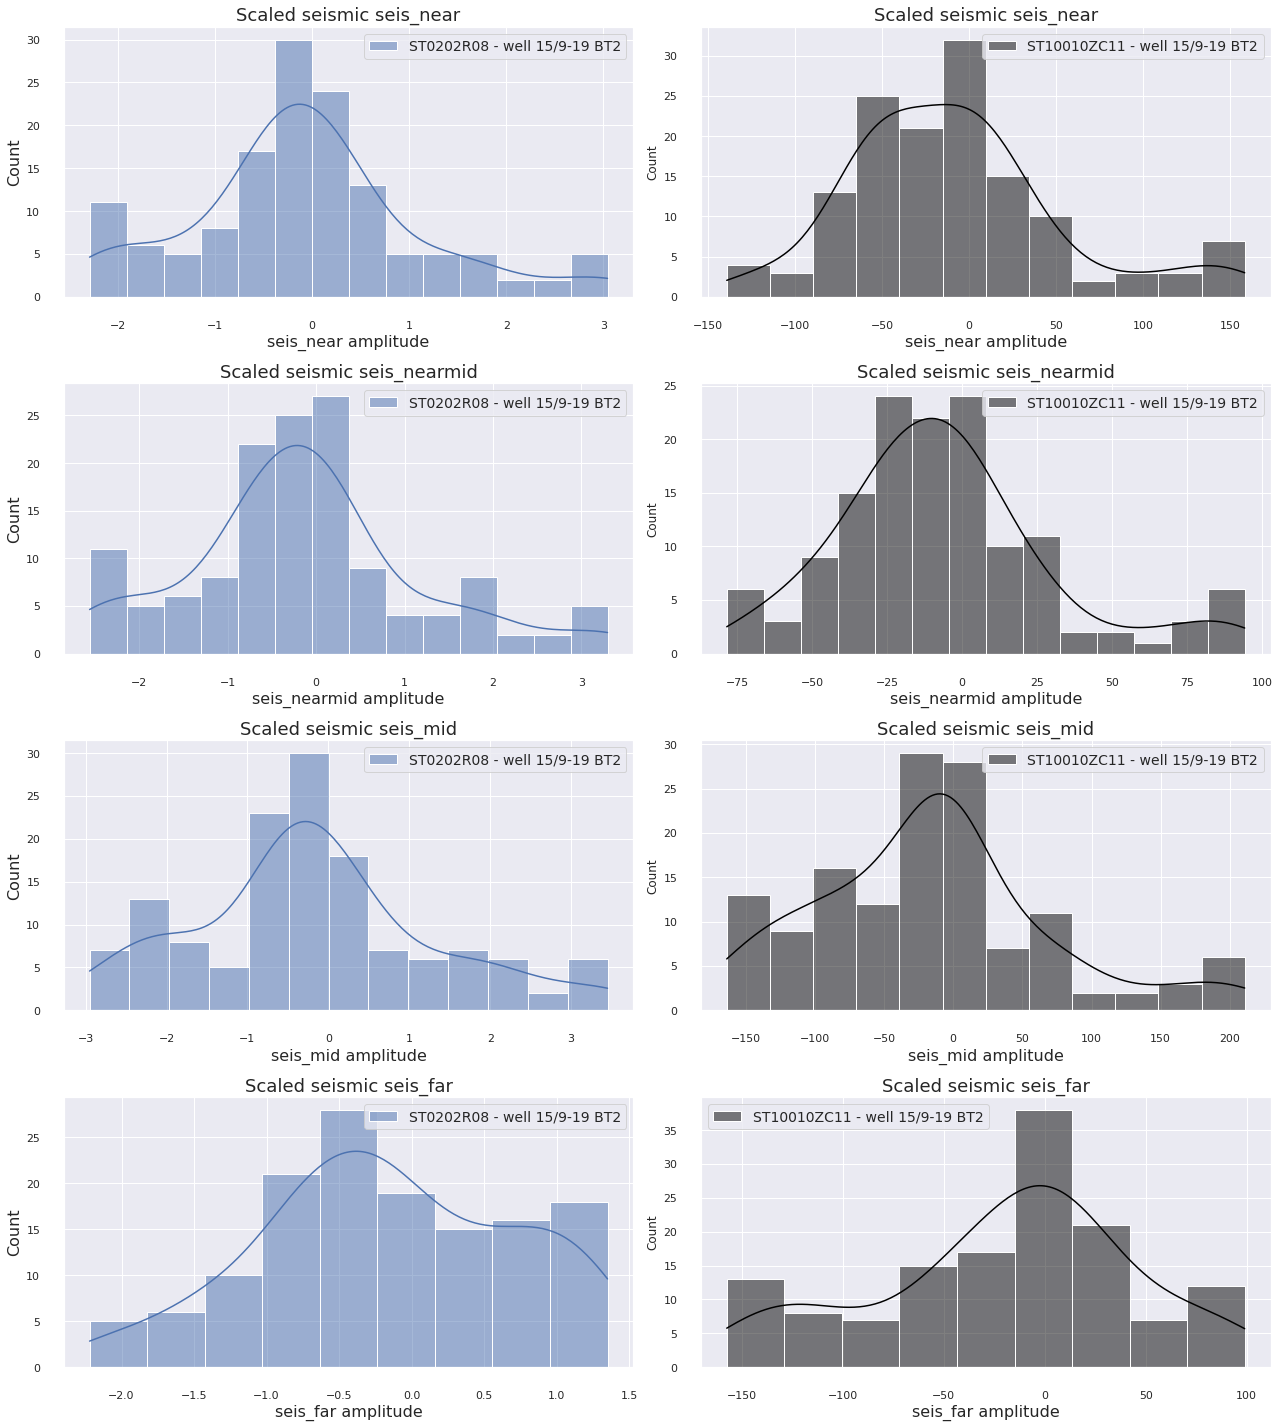

In [68]:
#  Categorical Data
features = ['seis_near', 'seis_nearmid', 'seis_mid', 'seis_far']


#  Categorical Data
a = 4  # number of rows
b = 2  # number of columns
c = 1  # initialize plot counter

fig = plt.figure(figsize=(18,20))


for feature in features:

    plt.subplot(a, b, c)

    plt.title('Scaled seismic {}'.format(feature), fontsize = 18)
    plt.xlabel(f'{feature} amplitude', fontsize = 16)
    hist1 = sns.histplot(dataset_bt2_old.X_scaled[feature],kde = True,label = f'ST0202R08 - well {wells_val[0]}')
    hist1.tick_params(axis = 'both', size = 20)

    hist1.set_ylabel("Count",fontsize=16)
    plt.legend()

    plt.subplot(a, b, c+1)

    plt.title('Scaled seismic {}'.format(feature), fontsize = 18)
    plt.xlabel(f'{feature} amplitude', fontsize = 16)
    hist2 = sns.histplot(dataset_bt2_new.X_scaled[feature], kde=True,color = 'black', label = f'ST10010ZC11 - well {wells_test[0]}')
    hist2.tick_params(axis = 'both', size = 20)




    plt.legend()
    c +=2

plt.subplots_adjust(wspace = 2)
plt.subplots_adjust(hspace = 2)
plt.tight_layout()

### Conclusion

    By the plot above we conclude that partial seismic data is significantly different when it comes to 2008 and 2011 vintage comparison. Potential solution that could lead us to resolve scale issue:

1. Standardization of the whole seismic data - 2008 and 2011 separately. Standadization should be applied on the whole sesmic data, and not only on the portion of the data that is linked to the well data
2. We can also use different robust scaler for different vintage (then plot them to observe similarities/differences). It's something to try since we are now using the same scaler for old and new vintage. Same scaler implies same parameters of scaling and that's why it affects different vintages in different way